# Impact Function Calibration

CLIMADA provides the `climada.util.calibrate`  module for calibrating impact functions based on impact data.
This tutorial will guide through the usage of this module by calibrating an impact function for tropical cyclones (TCs).

For further information on the classes available from the module, see its [documentation](../climada/climada.util.calibrate).

## Overview

The basic idea of the calibration is to find a set of parameters for an impact function that minimizes the deviation between the calculated impact and some impact data.

In [2]:
import logging
import climada

logging.getLogger("climada").setLevel("WARNING")

## Calibration Data

CLIMADA ships data from the International Disaster Database EM-DAT, which we will use to calibrate impact functions on.
In the first step, we will select TC events that caused damages in the `NA1` basin since 2010.

We use EMDAT data from TCs occurring in the `NA1` basin since 2010.
We calculate the centroids for which we want to compute the windfields by extracting the countries hit by the cyclones and retrieving a `LitPop` exposure instance from them.
We then use the exposure coordinates as centroids coordinates.

In [3]:
import pandas as pd
from climada.util.constants import SYSTEM_DIR

emdat = pd.read_csv(SYSTEM_DIR / "tc_impf_cal_v01_EDR.csv")
emdat_subset = emdat[(emdat.cal_region2 == "NA1") & ((emdat.year >= 2010))]
emdat_subset

,country,region_id,cal_region2,year,EM_ID,ibtracsID,emdat_impact,reference_year,emdat_impact_scaled,climada_impact,...,scale,log_ratio,unique_ID,Associated_disaster,Surge,Rain,Flood,Slide,Other,OtherThanSurge
326,MEX,484,NA1,2010,2010-0260,2010176N16278,2.000000e+09,2014,2.485465e+09,2.478270e+09,...,1.0,-0.002899,2010-0260MEX,True,False,False,True,False,False,True
331,ATG,28,NA1,2010,2010-0468,2010236N12341,1.260000e+07,2014,1.394594e+07,1.402875e+07,...,1.0,0.005920,2010-0468ATG,True,False,False,True,False,False,True
334,MEX,484,NA1,2010,2010-0494,2010257N16282,3.900000e+09,2014,4.846656e+09,4.857140e+09,...,1.0,0.002161,2010-0494MEX,True,False,False,True,False,False,True
339,LCA,662,NA1,2010,2010-0571,2010302N09306,5.000000e+05,2014,5.486675e+05,5.492871e+05,...,1.0,0.001129,2010-0571LCA,True,False,False,True,True,False,True
340,VCT,670,NA1,2010,2010-0571,2010302N09306,2.500000e+07,2014,2.670606e+07,2.676927e+07,...,1.0,0.002364,2010-0571VCT,False,False,False,False,False,False,False
344,BHS,44,NA1,2011,2011-0328,2011233N15301,4.000000e+07,2014,4.352258e+07,4.339898e+07,...,1.0,-0.002844,2011-0328BHS,False,False,False,False,False,False,False
345,DOM,214,NA1,2011,2011-0328,2011233N15301,3.000000e+07,2014,3.428317e+07,3.404744e+07,...,1.0,-0.006900,2011-0328DOM,True,False,False,True,False,False,True
346,PRI,630,NA1,2011,2011-0328,2011233N15301,5.000000e+08,2014,5.104338e+08,5.139659e+08,...,1.0,0.006896,2011-0328PRI,True,False,False,True,False,False,True
352,MEX,484,NA1,2011,2011-0385,2011279N10257,2.770000e+07,2014,3.084603e+07,3.077374e+07,...,1.0,-0.002346,2011-0385MEX,True,False,False,True,True,False,True
359,MEX,484,NA1,2012,2012-0276,2012215N12313,3.000000e+08,2014,3.283428e+08,3.284805e+08,...,1.0,0.000419,2012-0276MEX,False,False,False,False,False,False,False


Each entry in the database refers to an economic impact for a specific country and TC event.
The TC events are identified by the ID assigned from the International Best Track Archive for Climate Stewardship (IBTrACS).
We now want to reshape this data so that impacts are grouped by event and country.

To achieve this, we iterate over the unique track IDs, select all reported damages associated with this ID, and concatenate the results.
For missing entries, `pandas` will set the value to NaN.
We assume that missing entries means that no damages are reported (this is a strong assumption), and set all NaN values to zero.
Then, we transpose the dataframe so that each row represents and event and each column states the damage for a specific country.
Finally, we set the track ID to be the index of the data frame.

In [4]:
track_ids = emdat_subset["ibtracsID"].unique()

# NOTE: We want a data frame where each row is one event and the columns list damages
#       per country.
data = (
    pd.concat(
        [
            emdat_subset.loc[emdat_subset["ibtracsID"] == track].set_index("region_id")[
                "emdat_impact_scaled"
            ]
            for track in track_ids
        ],
        axis=1,
    )
    .fillna(0)
    .transpose()
    .set_index(track_ids)
)
data.index.rename("ibtracsID", inplace=True)
data

region_id,484,28,662,670,44,214,630,388,132,192,659,796,92,212
ibtracsID,,,,,,,,,,,,,,
2010176N16278,2.485465e+09,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2010236N12341,0.000000e+00,1.394594e+07,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2010257N16282,4.846656e+09,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2010302N09306,0.000000e+00,0.000000e+00,548667.5019,26706058.15,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2011233N15301,0.000000e+00,0.000000e+00,0.0000,0.00,4.352258e+07,34283168.75,5.104338e+08,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2011279N10257,3.084603e+07,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2012215N12313,3.283428e+08,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2012166N09269,6.074341e+08,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00
2012296N14283,0.000000e+00,0.000000e+00,0.0000,0.00,0.000000e+00,0.00,0.000000e+00,15483975.86,0.000,0.000000e+00,0.00,0.0,0.000000e+00,0.000000e+00


This is the data against which we want to compare our model output.
Let's continue setting up the calibration!

## Model Setup

In the first step, we create the exposure layer for the model.
We use the `LitPop` module and simply pass the names of all countries listed in our calibration data to the `from_countries` classmethod.
The countries are the columns in the `data` object.

Alternatively, we could have inserted `emdat_subset["region_id"].unique().tolist()`.

In [5]:
from climada.entity.exposures.litpop import LitPop
from climada.util import log_level

# Calculate the exposure
with log_level("ERROR"):
    exposure = LitPop.from_countries(data.columns.tolist())


CLIMADA provides the `TCTracks` class, which lets us download the tracks of TCs using their IBTrACS IDs.
We then have to equalize the time steps of the different TC tracks.

The track and intensity of a cyclone are insufficient to compute impacts in CLIMADA.
We first have to re-compute a windfield from each track at the locations of interest.
For consistency, we simply choose the coordinates of the exposure.

2023-06-09 12:52:52,649 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2022-03-08 23:23:51 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /Users/ldr.riedel/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


/Users/ldr.riedel/mambaforge/envs/climada_env_3.9/lib/python3.9/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


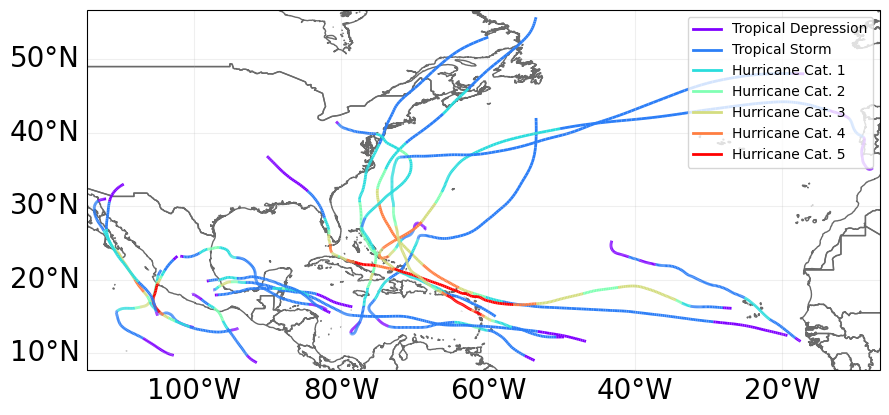

In [6]:
from climada.hazard import Centroids, TCTracks, TropCyclone

# Get the tracks for associated TCs
tracks = TCTracks.from_ibtracs_netcdf(storm_id=track_ids.tolist())
tracks.equal_timestep(time_step_h=1.0, land_params=False)
tracks.plot()

# Calculate windfield for the tracks
centroids = Centroids.from_lat_lon(exposure.gdf.latitude, exposure.gdf.longitude)
hazard = TropCyclone.from_tracks(tracks, centroids)


## Calibration Setup

We are now set up to define the specifics of the calibration task.
First, let us define the impact function we actually want to calibrate.
We select the formula by Emanuel (2011), for which a shortcut exists in the CLIMADA code base: `ImpfTropCyclone.from_emanuel_usa`.
The sigmoid-like impact function takes three parameters, the wind threshold for any impact `v_thresh`, the wind speed where half of the impact occurs `v_half`, and the maximum impact factor `scale`.
According to the model by Emanuel (2011), `v_thresh` is considered a constant, so we choose to only calibrate the latter two.

Any CLIMADA `Optimizer` will roughly perform the following algorithm:
1. Create a set of parameters and built an impact function (set) from it.
2. Compute an impact with that impact function set.
3. Compare the impact and the calibration data via the cost/target function.
4. Repeat N times or until the target function goal is reached.

The selection of parameters is based on the target function varies strongly between different optimization algorithms.

For the first step, we have to supply a function that takes the parameters we try to estimate and returns the impact function set that can later be used in an impact calculation.
We only calibrate a single function for the entire basin, so this is straightforward.

To ensure the impact function is applied correctly, we also have to set the `impf_` column of the exposure `GeoDataFrame`.
Note that the default impact function ID is 1, and that the hazard type is `"TC"`.

In [7]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

# Match impact function and exposure
exposure.gdf["impf_TC"] = 1

def impact_func_tc(v_half, scale):
    return ImpactFuncSet([ImpfTropCyclone.from_emanuel_usa(v_half=v_half, scale=scale)])

Defining the cost function is crucial for the result of the calibration.
You can choose what is best suited for your application.
Often, it is not clear which function works best, and it's a good idea to try out a few.
In this case, let's take a basic one, the root mean squared error (RMSE).

The cost function must be defined as a function that takes the impact object calculated by the optimization algorithm and the input calibration data as arguments, and that returns a single number.
This number represents a "cost" of the parameter set used for calculating the impact.
A higher cost therefore is worse, a lower cost is better.
Any optimizer will try to minimize the cost.

Note that the impact object is an instance of `Impact`, whereas the input calibration data is a `pd.DataFrame`.
To compute the RMSE, we first have to transform the impact into the same data structure, meaning that we have to aggregate the point-wise impacts by event and country.
This is easily achieved with the `Impact.impact_at_reg` function.
If we do not supply any arguments, this function will automatically determine the country for every exposure location and aggregate accordingly.
This can be computationally expensive.
Luckily, we know this information already and can supply the region ID directly via the exposure `GeoDataFrame`.

Computations on data frames align columns and indexes.
The indexes of the calibration data are the IBTrACS IDs, but the indexes of the result of `Impact.impact_at_reg` are the hazard event IDs, which at this point are only integer numbers.
To resolve that, we simply set the hazard event IDs to the IBTrACS IDs, which are stored in `Hazard.event_name`.
Once both the impact data and the calibration data are in the same data format, we can compute the RMSE:

In [8]:
import numpy as np
from climada.engine import Impact

# Make sure that Hazard.event_id matches indexes of 'data'
hazard.event_id = np.asarray(hazard.event_name)

def cost_rmse(impact: Impact, data: pd.DataFrame):
    """A cost function computing the RMSE"""
    impact = impact.impact_at_reg(exposure.gdf["region_id"])
    return np.sqrt(np.mean(((data - impact) ** 2).to_numpy()))

We will be using the `BayesianOptimizer`, which only requires one other input: The bounds of the parameters.
Initial values are not needed because the optimizer first samples the bound parameter space uniformly and then iteratively "narrows down" the search.
We choose a `v_half` between `v_thresh` and 150, and a scale between 0.01 (it must never be zero) and 1.0.
Specifying the bounds as dictionary (a must in case of `BayesianOptimizer`) also serves the purpose of naming the parameters we want to calibrate.
Notice that these names have to match the arguments of the impact function generator.

In [9]:
bounds = {"v_half": (25.7, 150), "scale": (0.01, 1)}

## Execute the Calibration

Now we can finally execute our calibration task!
We will plug all input parameters in an instance of `Input`, and then create the optimizer instance with it.
The `Optimizer.run` method returns an `Output` object, whose `params` attribute holds the optimal parameters determined by the calibration.

Notice that the `BayesianOptimization` *maximizes* a target function.
Therefore, higher target values are *better* than lower ones in this case.

In [10]:
from climada.util.calibrate import Input, BayesianOptimizer

# Define calibration input
input = Input(
    hazard=hazard,
    exposure=exposure,
    data=data,
    cost_func=cost_rmse,
    impact_func_gen=impact_func_tc,
    bounds=bounds,
)

# Create and run the optimizer
opt = BayesianOptimizer(input)
output = opt.run()
output.params  # The optimal parameters

|   iter    |  target   |   scale   |  v_half   |
-------------------------------------------------
| 3         | 3.057e-10 | 0.1553    | 37.18     |
| 17        | 3.202e-10 | 0.9583    | 91.97     |
| 18        | 5.243e-10 | 0.695     | 64.92     |
| 24        | 9.24e-10  | 0.9095    | 62.2      |
| 68        | 9.292e-10 | 0.8026    | 54.66     |
| 105       | 9.807e-10 | 0.9563    | 62.37     |
| 108       | 9.893e-10 | 0.9613    | 62.27     |
| 109       | 1.014e-09 | 0.9882    | 61.96     |
| 117       | 1.014e-09 | 0.9903    | 61.51     |


{'scale': 0.9903198881207879, 'v_half': 61.51163348395183}

## Analyze the Calibration

Now that we obtained a calibration result, we should investigate it further.
The most straightforward thing is to plot the impact function defined by the optimal parameters:

<AxesSubplot:title={'center':'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

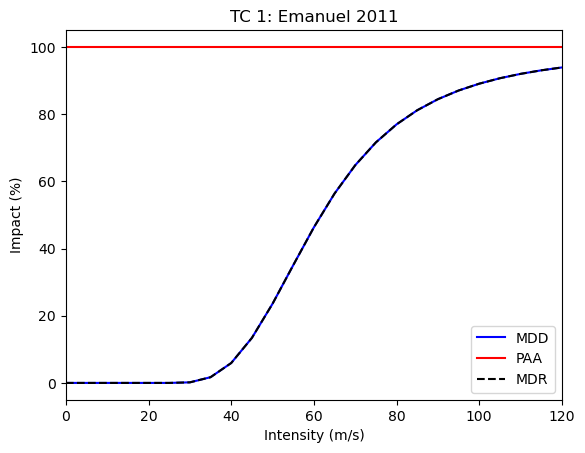

In [11]:
from climada.entity import ImpfTropCyclone

ImpfTropCyclone.from_emanuel_usa(**output.params).plot()

The Bayesian Optimizer returns the entire paramter space it sampled.
We can find out a lot about the relation of the fitted parameters by investigating how the target function value depends on them.
Since we only calibrated two values, we can plot them in a scatter plot.
To that end, retrieving the parameter space data via `BayesianOptimizerOutput.param_space_to_dataframe` will help.
Notice that the optimal parameter set is not necessarily the last entry in the parameter space!

In [12]:
p_space_df = output.p_space_to_dataframe()
p_space_df

,scale,v_half,target
0,0.422852,115.236335,2.405716e-10
1,0.010113,63.279939,2.280614e-10
2,0.155288,37.177687,3.057439e-10
3,0.194398,68.653198,2.637483e-10
4,0.402800,92.674920,2.571778e-10
...,...,...,...
195,0.980632,47.015299,3.576957e-10
196,0.943001,147.501934,2.396817e-10
197,0.999377,70.913361,6.412774e-10
198,0.997574,64.547339,9.480593e-10


Therefore, let's order the parameter space by the descending target function values.

In [13]:
p_space_df = p_space_df.sort_values("target", ascending=False)
p_space_df

,scale,v_half,target
116,0.990320,61.511633,1.013992e-09
108,0.988234,61.959510,1.013962e-09
110,0.982902,61.693392,1.013046e-09
170,0.978972,61.694825,1.011628e-09
119,0.997161,61.119598,1.007215e-09
...,...,...,...
91,0.755228,33.970485,2.088355e-10
194,0.980303,38.162301,1.980600e-10
66,0.565420,28.017858,1.792657e-10
74,0.564120,27.260708,1.737898e-10


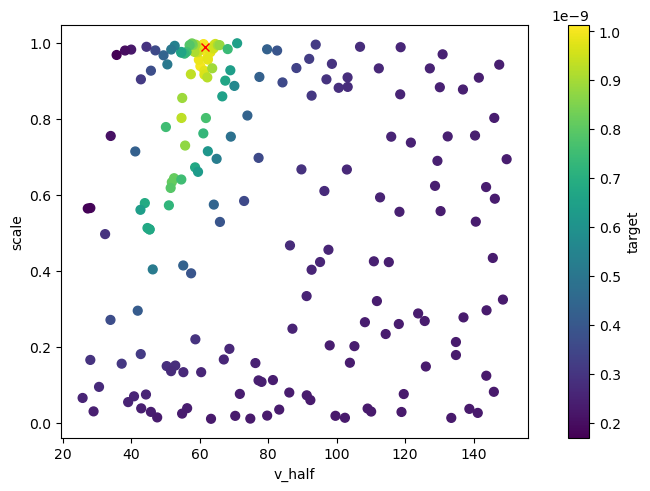

In [17]:
import matplotlib.pyplot as plt

# Plot parameter space as scatter plot
fig, ax = plt.subplots(1, 1, constrained_layout=True)
p_space_df.plot(ax=ax, kind="scatter", x="v_half", y="scale", c="target", s=40)

# Plot the optimal value as "x"
best = p_space_df.iloc[0]
ax.plot(best["v_half"], best["scale"], "x", color="r")


The target function has limited meaning outside the calibration task.
To investigate the quality of the calibration, it is helpful to compute the impact with the impact function defined by the optimal parameters.

In [19]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone
from climada.engine import ImpactCalc

impf = ImpactFuncSet([ImpfTropCyclone.from_emanuel_usa(**output.params)])
impact = ImpactCalc(exposure, impf, hazard).impact(assign_centroids=False)
impact_data = impact.impact_at_reg(exposure.gdf["region_id"])
impact_data

,28,44,92,132,192,212,214,388,484,630,659,662,670,796
2010176N16278,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.221970e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2010236N12341,9.610111e+06,0.000000e+00,2.390220e+07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.872097e+07,4.721180e+06,0.000000e+00,0.000000e+00,0.000000e+00
2010257N16282,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.025816e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2010302N09306,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.233805e+06,1.661492e+06,1.592062e+05
2011233N15301,0.000000e+00,5.448132e+08,1.225244e+07,0.000000,0.000000e+00,0.000000e+00,2.801224e+04,0.000000e+00,0.000000e+00,2.893259e+08,0.000000e+00,0.000000e+00,0.000000e+00,7.066280e+07
2011279N10257,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.262122e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2012166N09269,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.599307e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2012215N12313,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.136151e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2012296N14283,0.000000e+00,5.475790e+07,0.000000e+00,0.000000,1.526213e+09,0.000000e+00,0.000000e+00,1.639855e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2014253N13260,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.094890e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


We can now compare the modelled and reported impact data on a country- or event-basis.
Recall that in this representation, the rows represent events and the columns countries.
So we sum over rows or columns, concatenate the result column-wise, rename the columns, and plot the data.

For the countries, it is helpful to display the true country name instead of the country ID.

<AxesSubplot:ylabel='Damages (USD)'>

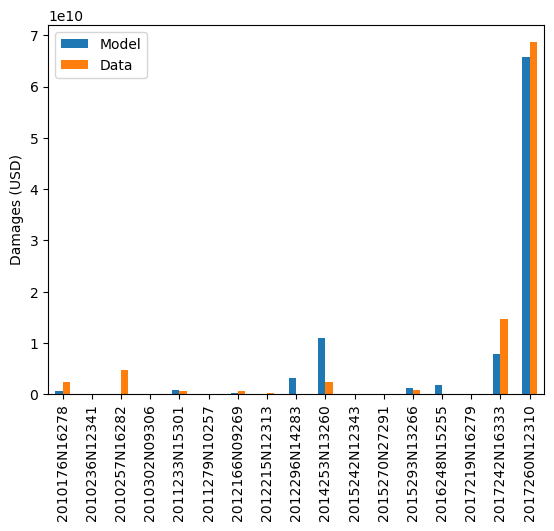

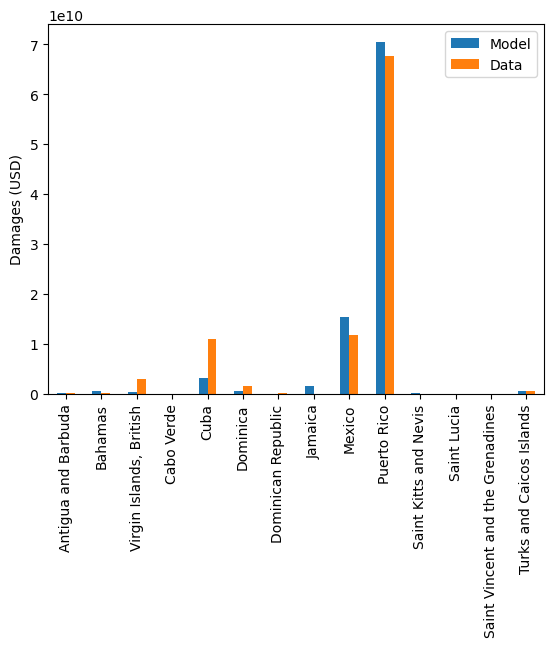

In [40]:
import pandas as pd
import pycountry
import climada.util.coordinates as u_coord

log_scale = False
ylabel = f"Damages ({exposure.value_unit})"

# Plot: Per event
merged = pd.concat(
    [impact_data.sum(axis="columns"), data.sum(axis="columns")], axis=1
).rename(columns={0: "Model", 1: "Data"})
merged.plot.bar(logy=log_scale, ylabel=ylabel)

# Mapping from country ID to country name
country_name_map = {
    country_id: pycountry.countries.lookup(
        u_coord.country_to_iso(country_id, representation="alpha3")
    ).name
    for country_id in data.columns.tolist()
}

# Plot: Per country
merged = (
    pd.concat([impact_data.sum(axis="rows"), data.sum(axis="rows")], axis=1)
    .rename(columns={0: "Model", 1: "Data"})
    .rename(index=country_name_map)
)
merged.plot.bar(logy=log_scale, ylabel=ylabel)


Finally, we can do an event- *and* country-based comparison using a heatmap.
Since the magnitude of the impact values may differ strongly, we will compare them on a logarithmic scale.
We will divide each modelled impact by the observed impact and take the the decadic logarithm.
The result will tell us how many orders of magnitude our model was off.
Note that to avoid infinite values and NaNs, we will add 1 to each of the data points

,Antigua and Barbuda,Bahamas,"Virgin Islands, British",Cabo Verde,Cuba,Dominica,Dominican Republic,Jamaica,Mexico,Puerto Rico,Saint Kitts and Nevis,Saint Lucia,Saint Vincent and the Grenadines,Turks and Caicos Islands
2010176N16278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.536752,NaN,NaN,NaN,NaN,NaN
2010236N12341,-0.161719,NaN,7.378438,NaN,NaN,NaN,NaN,NaN,NaN,7.458199,6.674051,NaN,NaN,NaN
2010257N16282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.984236,NaN,NaN,NaN,NaN,NaN
2010302N09306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.770404,-1.206111,5.201963
2011233N15301,NaN,1.097533,7.088223,NaN,NaN,NaN,-3.087718,NaN,NaN,-0.246552,NaN,NaN,NaN,7.849191
2011279N10257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.628136,NaN,NaN,NaN,NaN,NaN
2012166N09269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.368642,NaN,NaN,NaN,NaN,NaN
2012215N12313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.460891,NaN,NaN,NaN,NaN,NaN
2012296N14283,NaN,7.738447,NaN,NaN,9.183615,NaN,NaN,2.024923,NaN,NaN,NaN,NaN,NaN,NaN
2014253N13260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.641430,NaN,NaN,NaN,NaN,NaN


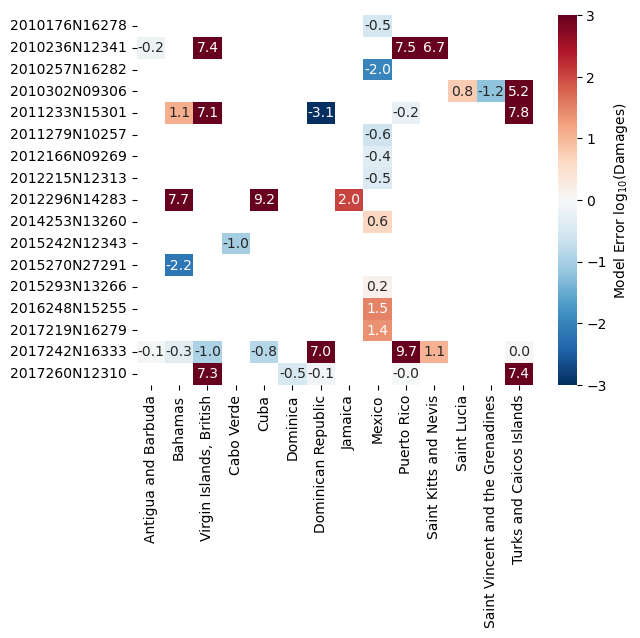

In [42]:
import numpy as np
import seaborn as sns

diff = (impact_data + 1) / (data + 1)
diff = diff.transform(np.log10).replace(0, np.nan)
diff = diff.rename(columns=country_name_map)
sns.heatmap(
    diff,
    annot=True,
    vmin=-3,
    vmax=3,
    center=0,
    fmt=".1f",
    cmap="RdBu_r",
    cbar_kws=dict(label=r"Model Error $\log_{10}(\mathrm{Damages})$"),
)
diff


## How to Continue

While the found impact function looks reasonable, we find that the model overestimates the impact severely for several events.
This might be due to missing data, but it is also strongly related to the choice of impact function (shape) and the particular goal of the calibration task.

The most crucial information in the calibration task is the cost function.
The RMSE measure is sensitive to the largest errors (and hence the largest impact).
Therefore, using it in the calibration minimizes the overall error, but will incorrectly capture events with impact of lower orders of magnitude.
Using a cost function based on the ratio between modelled and observed impact might increase the overall error but decrease the log-error for many events.

So we present some ideas on how to continue and/or improve the calibration:
1. Use a different cost function
2. Employ the `ScipyMinimizeOptimizer` instead of the `BayesianOptimizer`

In [70]:
import pandas as pd
from climada.engine import Impact

# Define a cost function
def cost_rmsle(impact: Impact, data: pd.DataFrame):
    impact = impact.impact_at_reg(exposure.gdf["region_id"])
    data, impact = data.align(impact, "outer", fill_value=0)
    data, impact = data.to_numpy(), impact.to_numpy()
    return np.exp(np.sqrt(np.mean((np.log(data + 1) - np.log(impact + 1)) ** 2)) - 1)

def cost_rmse(impact: Impact, data: pd.DataFrame):
    impact = impact.impact_at_reg(exposure.gdf["region_id"])
    return np.sqrt(np.mean(((data - impact) ** 2).to_numpy()))
